# Random Acts of Pizza

I will use Kaggle's Random Accts of Pizza classification task for my project.

https://www.kaggle.com/c/random-acts-of-pizza

Let's start by importing some libraries and loading the data into an ndarray.

In [65]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import cross_validation

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [2]:
# Load the data
import urllib
import tarfile
import pandas as pd


# download the data and extract the tarball 
tf = urllib.URLopener()

# change the url to http from https if you get a urllib error
tf.retrieve("https://cs.stanford.edu/~althoff/raop-dataset/pizza_request_dataset.tar.gz", "pizza.tar.gz")

tar = tarfile.open("pizza.tar.gz", "r:gz")
for name in tar.getnames():
    if name == "pizza_request_dataset/pizza_request_dataset.json":
        member = tar.getmember(name)
        f = tar.extractfile(member)
        if f is not None:
            json_data = f.read()

# convert data to a pandas dataframe
pizza_df = pd.read_json(json_data)
print(pizza_df[:0])
pizza_df = np.asarray(pizza_df)

# shuffle the data
np.random.seed(0)
shuffle = np.random.permutation(np.arange(pizza_df.shape[0]))
pizza_df = pizza_df[shuffle]

# extract test and train data and labels
dev_data, dev_labels = np.delete(pizza_df[:500], 23, axis=1), [x for x in pizza_df[:500, 23]]
test_data, test_labels = np.delete(pizza_df[500:1000], 23, axis=1), [x for x in pizza_df[500:1000, 23]]
train_data, train_labels = np.delete(pizza_df[1000:], 23, axis=1), [x for x in pizza_df[1000:, 23]]

Empty DataFrame
Columns: [giver_username_if_known, in_test_set, number_of_downvotes_of_request_at_retrieval, number_of_upvotes_of_request_at_retrieval, post_was_edited, request_id, request_number_of_comments_at_retrieval, request_text, request_text_edit_aware, request_title, requester_account_age_in_days_at_request, requester_account_age_in_days_at_retrieval, requester_days_since_first_post_on_raop_at_request, requester_days_since_first_post_on_raop_at_retrieval, requester_number_of_comments_at_request, requester_number_of_comments_at_retrieval, requester_number_of_comments_in_raop_at_request, requester_number_of_comments_in_raop_at_retrieval, requester_number_of_posts_at_request, requester_number_of_posts_at_retrieval, requester_number_of_posts_on_raop_at_request, requester_number_of_posts_on_raop_at_retrieval, requester_number_of_subreddits_at_request, requester_received_pizza, requester_subreddits_at_request, requester_upvotes_minus_downvotes_at_request, requester_upvotes_minus_down

## Establishing a baseline

Let's establish a baseline using BernoulliNB, MultinomialNB and LogisticRegression. We will use just the post text (corresponding to column 7 in pizza_df) and the "requester_received_pizza" outcome (True, False).

In [3]:

# define a helper function to perform the analysis 
def perform_analysis(train_data, train_labels, dev_data, dev_features, 
                     vectorizer=CountVectorizer(), clf = BernoulliNB(), 
                     gsc_params = {}):
    
    train_data_features = vectorizer.fit_transform(train_data)
    dev_data_features = vectorizer.transform(dev_data)
    
    print("RESULTS FOR Default %s : -------------------------------" % (clf))
    clf.fit(train_data_features, train_labels)
    print("f1_score: %s\naccuracy_score: %s\nroc_auc_score: %s\n" 
              % (metrics.f1_score(dev_labels, clf.predict(dev_data_features)), 
          metrics.accuracy_score(dev_labels, clf.predict(dev_data_features)), 
                metrics.roc_auc_score(dev_labels, clf.predict(dev_data_features))))
    
    print("Calculating Cross Vaidation Scores: ")
    scores = cross_validation.cross_val_score(clf, train_data_features, train_labels, cv=10, scoring='f1_weighted')
    print("Scores: %s\n" % (scores))
    
    # Search for the best estimator
    print("STARTING GRID SEARCH...")
    gsc = GridSearchCV(clf, gsc_params, n_jobs=-1)
    gsc.fit(train_data_features, train_labels)
    print("Best estimator: %s\nBest alpha: %s\nBest score: %s\nScorer function: %s\n" 
          % (gsc.best_estimator_, gsc.best_params_, gsc.best_score_, gsc.scorer_))
    # return gsc.best_estimator_

In [4]:
# BernoulliNB using CountVectorizer
print("BernoulliNB using CountVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=CountVectorizer(), clf = BernoulliNB(), 
                 gsc_params = {'alpha': np.arange(0, 1, 0.01)})

# BernoulliNB using TfidfVectorizer
print("BernoulliNB using TfidfVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english'), clf = BernoulliNB(), 
                 gsc_params = {'alpha': np.arange(0, 1, 0.01)})

BernoulliNB using CountVectorizer
RESULTS FOR Default BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) : -------------------------------
f1_score: 0.305555555556
accuracy_score: 0.7
roc_auc_score: 0.554981518817

Calculating Cross Vaidation Scores: 
Scores: [ 0.68923924  0.69364719  0.68049658  0.67924009  0.69507729  0.69611298
  0.67960775  0.66109026  0.68012268  0.67949566]

STARTING GRID SEARCH...
Best estimator: BernoulliNB(alpha=0.0, binarize=0.0, class_prior=None, fit_prior=True)
Best alpha: {'alpha': 0.0}
Best score: 0.737315350032
Scorer function: <function _passthrough_scorer at 0x0000000007E8E0B8>

BernoulliNB using TfidfVectorizer
RESULTS FOR Default BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) : -------------------------------
f1_score: 0.212290502793
accuracy_score: 0.718
roc_auc_score: 0.531207997312

Calculating Cross Vaidation Scores: 
Scores: [ 0.6948353   0.69313005  0.70509014  0.69313005  0.70155229  0.67149621
  0.6

In [5]:
# MultinomialNB using CountVectorizer
print("MultinomialNB using CountVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=CountVectorizer(), clf = MultinomialNB(), 
                 gsc_params = {'alpha': np.arange(0, 1, 0.01)})

# MultinomialNB using TfidfVectorizer
print("MultinomialNB using TfidfVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english'), clf = MultinomialNB(), 
                 gsc_params = {'alpha': np.arange(0, 1, 0.01)})

MultinomialNB using CountVectorizer
RESULTS FOR Default MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) : -------------------------------
f1_score: 0.0915032679739
accuracy_score: 0.722
roc_auc_score: 0.503150201613

Calculating Cross Vaidation Scores: 
Scores: [ 0.69658503  0.67541664  0.67977306  0.67645383  0.69491832  0.6602577
  0.6839763   0.63693178  0.64502397  0.6718563 ]

STARTING GRID SEARCH...
Best estimator: MultinomialNB(alpha=0.98999999999999999, class_prior=None, fit_prior=True)
Best alpha: {'alpha': 0.98999999999999999}
Best score: 0.731749090131
Scorer function: <function _passthrough_scorer at 0x0000000007E8E0B8>

MultinomialNB using TfidfVectorizer
RESULTS FOR Default MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) : -------------------------------
f1_score: 0.0
accuracy_score: 0.744
roc_auc_score: 0.5

Calculating Cross Vaidation Scores: 
Scores: [ 0.64573692  0.64468864  0.64573692  0.64573692  0.64790979  0.64790979
  0.64790979  0.64719664 

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best estimator: MultinomialNB(alpha=0.91000000000000003, class_prior=None, fit_prior=True)
Best alpha: {'alpha': 0.91000000000000003}
Best score: 0.75294369514
Scorer function: <function _passthrough_scorer at 0x0000000007E8E0B8>



In [6]:
# LogisticRegression using CountVectorizer
print("LogisticRegression using CountVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=CountVectorizer(), clf = LogisticRegression(), 
                 gsc_params = {'C': np.arange(0.01, 1, 0.01)})

# LogisticRegression using TfidfVectorizer
print("LogisticRegression using TfidfVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=TfidfVectorizer(), clf = LogisticRegression(), 
                 gsc_params = {'C': np.arange(0.01, 1, 0.01)})

LogisticRegression using CountVectorizer
RESULTS FOR Default LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) : -------------------------------
f1_score: 0.209523809524
accuracy_score: 0.668
roc_auc_score: 0.50529233871

Calculating Cross Vaidation Scores: 
Scores: [ 0.71056113  0.70374342  0.68475426  0.70022931  0.66436359  0.68405106
  0.69450078  0.657613    0.68159917  0.70261076]

STARTING GRID SEARCH...
Best estimator: LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best alpha: {'C': 0.02}
Best score: 0.754656390495
Scorer function: <function _passthrou

In [7]:
# KNeighborsClassifier using CountVectorizer
print("KNeighborsClassifier using CountVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=CountVectorizer(), clf = KNeighborsClassifier(), 
                 gsc_params = {'n_neighbors': np.arange(1, 100, 1)})

# KNeighborsClassifier using TfidfVectorizer
print("KNeighborsClassifier using TfidfVectorizer")
perform_analysis(train_data[:, 7], train_labels, dev_data[:, 7], dev_labels, 
                 vectorizer=TfidfVectorizer(), clf = KNeighborsClassifier(), 
                 gsc_params = {'n_neighbors': np.arange(1, 100, 1)})

KNeighborsClassifier using CountVectorizer
RESULTS FOR Default KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') : -------------------------------
f1_score: 0.103896103896
accuracy_score: 0.724
roc_auc_score: 0.507056451613

Calculating Cross Vaidation Scores: 
Scores: [ 0.66880342  0.65150464  0.67415834  0.66070829  0.65334379  0.66829823
  0.64546451  0.65698709  0.66896721  0.64462871]

STARTING GRID SEARCH...
Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=52, p=2,
           weights='uniform')
Best alpha: {'n_neighbors': 52}
Best score: 0.75315778206
Scorer function: <function _passthrough_scorer at 0x0000000007E8E0B8>

KNeighborsClassifier using TfidfVectorizer
RESULTS FOR Default KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_para

As we see above, using default options with KNearestNeighbors, BernoulliNB, MultinomialNB and LogisticRegression yielded accuracy better that random guessing. All three classifiers scored between approximately 70% to 75%. We can use this as a baseline and look to improve the score.

## A better baseline?

I suppose 75% accuracy is a good baseline to start with. Let's look to improve this in the next steps. I will try a pipeline as the first attempt.

### Using a Pipeline (chaining classifiers)

Let's see if chained transformation via CountVectorizer and TfiddfTransformer, followed by LogisticRegression, improves the results.


In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

# let's learn about pipelines; they will come in handy for ensembles
# ****code below is taken from scikit-learn's documentation on pipelines****
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__n_iter': (10, 50, 80),
}
# **** end of code taken from scikit-learn's documentation ****

gsc = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
gsc.fit(train_data[:, 7], train_labels)
print("Best estimator: %s\nBest alpha: %s\nBest score: %s\nScorer function: %s\n" 
      % (gsc.best_estimator_, gsc.best_params_, gsc.best_score_, gsc.scorer_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   18.4s finished


Best estimator: Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Best alpha: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'vect__max_df': 0.5}
Best score: 0.756797259687
Scorer function: <function _passthrough_scorer at 0x0000000007E8E0B8>



###  Randomized trees and Ensembles
Let's first look at the results of randomized trees and then use an ensemble (the VotingClassifier). Let's also convert user's subreddits to a "bag of words" and run that through randomized trees.

In [9]:
# Extremely Randomized Trees
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import ExtraTreesClassifier

vectorizer = HashingVectorizer(n_features=1000, analyzer='word', norm='l2', stop_words='english')
train_data_features = vectorizer.fit_transform(train_data[:, 7])
train_labels = [x for x in pizza_df[1000:, 23]]
dev_data_features = vectorizer.transform(dev_data[:, 7])
dev_labels = [x for x in pizza_df[:500, 23]]

clf = ExtraTreesClassifier(n_estimators=250, max_depth=None, 
                          min_samples_split=2, random_state=0, 
                          criterion='entropy')
clf.fit(train_data_features, train_labels)

print("ExtraTreesClassifier score: %s" % (clf.score(dev_data_features, dev_labels)))

print("ExtraTreesClassifier roc_auc_score: %s" % (metrics.roc_auc_score(dev_labels, clf.predict(dev_data_features))))

ExtraTreesClassifier score: 0.744
ExtraTreesClassifier roc_auc_score: 0.5


In [34]:
# Extremely Randomized Trees
# With subreddit membership as a bag of words
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import ExtraTreesClassifier

vectorizer = HashingVectorizer(n_features=1000, analyzer='word', norm='l2', stop_words='english')

td = [' '.join(x) for x in train_data[:, 23]]
dd = [' '.join(x) for x in dev_data[:, 23]]

train_data_features = vectorizer.fit_transform(td)
train_labels = [x for x in pizza_df[1000:, 23]]
dev_data_features = vectorizer.transform(dd)
dev_labels = [x for x in pizza_df[:500, 23]]

clf = ExtraTreesClassifier(n_estimators=250, max_depth=None, 
                          min_samples_split=2, random_state=0, 
                          criterion='entropy')
clf.fit(train_data_features, train_labels)

print("ExtraTreesClassifier score: %s" % (clf.score(dev_data_features, dev_labels)))
print("ExtraTreesClassifier roc_auc_score: %s" % (metrics.roc_auc_score(dev_labels, clf.predict(dev_data_features))))
print("ExtraTreesClassifier score: %s" % (clf.score(train_data_features, train_labels)))
print("ExtraTreesClassifier roc_auc_score: %s" % (metrics.roc_auc_score(train_labels, clf.predict(train_data_features))))

ExtraTreesClassifier score: 0.722
ExtraTreesClassifier roc_auc_score: 0.485215053763
ExtraTreesClassifier score: 0.955469920788
ExtraTreesClassifier roc_auc_score: 0.910169791786


In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

vectorizer = CountVectorizer()

dev_data, dev_labels = np.delete(pizza_df[:500], 23, axis=1), [x for x in pizza_df[:500, 23]]
train_data, train_labels = np.delete(pizza_df[1000:], 23, axis=1), [x for x in pizza_df[1000:, 23]]

train_data_features = vectorizer.fit_transform(train_data[:, 7])
dev_data_features = vectorizer.transform(dev_data[:, 7])

clf1 = KNeighborsClassifier()
clf2 = BernoulliNB()
clf3 = LogisticRegression()
clf4 = ExtraTreesClassifier(n_estimators=250, max_depth=None, 
                          min_samples_split=2, random_state=0, 
                          criterion='entropy')
vclf1 = VotingClassifier(estimators=[('knn', clf1), ('bnb', clf2), ('lr', clf3), ('etc', clf4)], voting='hard')

vclf1.fit(train_data_features, train_labels)
print("VotingClassifier accuracy score: %s" % (metrics.accuracy_score(dev_labels, vclf1.predict(dev_data_features))))
print("VotingClassifier roc_auc_score: %s" % (metrics.roc_auc_score(dev_labels, vclf1.predict(dev_data_features))))

print("VotingClassifier accuracy score: %s" % (metrics.accuracy_score(train_labels, vclf1.predict(train_data_features))))
print("VotingClassifier roc_auc_score: %s" % (metrics.roc_auc_score(train_labels, vclf1.predict(train_data_features))))

VotingClassifier accuracy score: 0.748
VotingClassifier roc_auc_score: 0.512936827957
VotingClassifier accuracy score: 0.868764718476
VotingClassifier roc_auc_score: 0.734402079723


I'm surprised to see that the ExtraTreesClassifier returns 72.2% accuracy for the subreddit membership which is marginally lower than the accuracy from the post itself (74%).
However, the overall accuracy is similar to the results of individual classifiers used earlier. It appears that a bag of words approach alone is not going to cut it. 

Let's look to improve upon this by first using a FeatureUnion on post words and subreddits (bag of words, yet again). After that I will look to expand the feature space.

## Feature Unions to improve the baseline


... to be continued

In [32]:
from __future__ import print_function 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC

# ItemSelector class COPIED VERBATIM from:
# http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

post_train_data = train_data[:, 7]
post_dev_data = dev_data[:, 7] 

title_train_data = train_data[:, 9]
title_dev_data = dev_data[:, 9] 


subreddits_train_data = [' '.join(x) for x in train_data[:, 23]] 
subreddits_dev_data = [' '.join(x) for x in dev_data[:, 23]]

pipeline_train_data = {'title': title_train_data, 
                       'posts': post_train_data, 
                       'subreddits': subreddits_train_data}

pipeline_dev_data = {'title': title_dev_data, 
                     'posts': post_dev_data, 
                     'subreddits': subreddits_dev_data}
pipeline = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                    ('title', Pipeline([
                                ('selector', ItemSelector(key='title')), 
                                ('cv', CountVectorizer()), 
                            ])),
                    
                    ('subreddits', Pipeline([
                                ('selector', ItemSelector(key='subreddits')), 
                                ('cv', CountVectorizer()), 
                            ])),
                    ('post', Pipeline([
                                ('selector', ItemSelector(key='posts')), 
                                ('vect', TfidfVectorizer(min_df=0.01, stop_words='english')), 
                                ('best', TruncatedSVD(n_components=50)), 
                            ])), 
                    
                ], 
            transformer_weights={
                    'title': 0.5,
                    'subreddits': 0.4, 
                    'post': 0.7, 
                }, 
            )), 
        ('clf', ExtraTreesClassifier(n_estimators=250, max_depth=None, 
                          min_samples_split=2, random_state=0, 
                          criterion='entropy'))
    ])

pipeline.fit(pipeline_train_data, train_labels)

print("Pipeline accuracy score: %s" % (metrics.accuracy_score(dev_labels, pipeline.predict(pipeline_dev_data))))
print("Pipeline roc_auc_score: %s" % (metrics.roc_auc_score(dev_labels, pipeline.predict(pipeline_dev_data))))

print("Pipeline accuracy score: %s" % (metrics.accuracy_score(train_labels, pipeline.predict(pipeline_train_data))))
print("Pipeline roc_auc_score: %s" % (metrics.roc_auc_score(train_labels, pipeline.predict(pipeline_train_data))))

Pipeline accuracy score: 0.746
Pipeline roc_auc_score: 0.50390625
Pipeline accuracy score: 1.0
Pipeline roc_auc_score: 1.0



Now ain't that a b\*\*\*\*\!

It looks like a bag-of-words approach is not going to cut it. But all is not lost yet. We can start adding some other features.


## Paying it forward, reciprocity, give & take

Let's evaluate notions of give and take and reciprocity in the posts. May be the potential for getting something in return affects people's decision to buy some random person a pizza.

In [87]:
from collections import defaultdict

reciprocity_terms = ['pay it forward', 'paying it forward', 'forward',  
                     'reciprocate', 'give back', 'trade', 'pay it back'
                    'pic', 'pics', 'story', 'stories']

def is_phrase_found(phrase_list, target_text):
    found = False
    for t in reciprocity_terms:
        if t in target_text:
            found = True
            break
    return found

def get_phrase_freq(phrase_list, target_text):
    found = 0
    for t in reciprocity_terms:
        for d in target_text:
            if t in d:
                found += 1
    return found

def calc_odds(data, query_terms):
    f = 0.
    for d in data:
        if(is_phrase_found(query_terms, d)):
            f += 1
    return f / len(data)

train_gotpizza = pizza_df[1000:][pizza_df[1000:][:, 23] == True][:, 7]
train_nopizza = pizza_df[1000:][pizza_df[1000:][:, 23] == False][:, 7]
dev_gotpizza = pizza_df[:500][pizza_df[:500][:, 23] == True][:, 7]
dev_nopizza = pizza_df[:500][pizza_df[:500][:, 23] == False][:, 7]

print("Prob. of NOT getting pizza: %.2f" % (len(train_nopizza) / float(len(train_data))))
p1 = calc_odds(train_nopizza, reciprocity_terms)
print("Prob. of NOT getting pizza given reciprocity: %.2f \n" % p1)

p2 = len(train_gotpizza) / float(len(train_data))
print("Prob. of getting pizza: %.2f" % p2)
p3 = calc_odds(train_gotpizza, reciprocity_terms)
print("Prob. of getting pizza given reciprocity: %.2f \n" % p3)

p4 = calc_odds(train_data[:, 7], reciprocity_terms)
print("Prob. of reciprocity in all posts: %.2f \n" % p4)

# Calculate the posterior odds of the desired Event (E), that is getting a pizza
# P(E | x) = p(x | E) * p(E) / p(x) 
print("Posterior prob. of getting pizza given reciprocity: %.2f" % ( p3 * p2 / p4))

Prob. of NOT getting pizza: 0.75
Prob. of NOT getting pizza given reciprocity: 0.20 

Prob. of getting pizza: 0.25
Prob. of getting pizza given reciprocity: 0.26 

Prob. of reciprocity in all posts: 0.22 

Posterior prob. of getting pizza given reciprocity: 0.29


Knowing that reciprocity has a bit of an effect on the likelihood of a post getting a pizza, let's add that as a feature to our pipeline. So may be we can hand adjust the probability of getting a pizza for posts that contain a notion of reciprocity.

In [14]:
vectorizer = CountVectorizer(ngram_range=(2, 3))
train_data_features = vectorizer.fit_transform(train_data[:, 7])
train_labels = [x for x in pizza_df[1000:, 23]]

dev_data_features = vectorizer.transform(dev_data[:, 7])
dev_labels = [x for x in pizza_df[:500, 23]]

et = ExtraTreesClassifier(n_estimators=250, max_depth=None, 
                          min_samples_split=2, random_state=0, 
                          criterion='entropy')

et.fit(train_data_features, train_labels)
print("Prior accuracy score: %s" % metrics.accuracy_score(dev_labels, et.predict(dev_data_features)))

dev_probs = et.predict_proba(dev_data_features)
for i, t in enumerate(dev_data[:, 7]):
    if(is_phrase_found(reciprocity_terms, t)):
        dev_probs[i][1] = dev_probs[i][1] * 1.16
# write our own prediction
dev_predicted_labels = []
for i, (f, t) in enumerate(dev_probs):
    if(t > f): 
        dev_predicted_labels.append(True)
    else:
        dev_predicted_labels.append(False)

print("Posterior accuracy score: %s" % metrics.accuracy_score(dev_labels, dev_predicted_labels))
print("Posterior roc_auc_score score: %s" % metrics.roc_auc_score(dev_labels, dev_predicted_labels))

Prior accuracy score: 0.746
Posterior accuracy score: 0.746
Posterior roc_auc_score score: 0.506468413978


So the simplistic approach of adjusting the probabilities did not work. We can still use this result though.

## Looking at Numeric Features

Since the bag of words approach alone did not fare much better than random guessing, at least in the roc_auc_score, let's look at some numeric features. As well as looking at features available directly in the data, we will also calcualte some numeric features: binary code reciprocity and calculate post length.


In [15]:
# Binary code reciprocity
reciproc_train_data = np.zeros(len(train_data[:, 7]))
reciproc_train_data.reshape(len(train_data[:, 7]), 1)
for i, t in enumerate(train_data[:, 7]):
    reciproc_train_data[i] = int(is_phrase_found(reciprocity_terms, t))

reciproc_dev_data = np.zeros(len(dev_data[:, 7]))
reciproc_dev_data.reshape(len(dev_data[:, 7]), 1)
for i, t in enumerate(dev_data[:, 7]):
    reciproc_dev_data[i] = int(is_phrase_found(reciprocity_terms, t)) 

# Calculate Post Length
length_train_post = np.zeros(len(train_data[:, 7]))
length_train_post.reshape(len(train_data[:, 7]), 1)
for i, t in enumerate(train_data[:, 7]):
    length_train_post[i] = len(t.split())

length_dev_post = np.zeros(len(dev_data[:, 7]))
length_dev_post.reshape(len(dev_data[:, 7]), 1)
for i, t in enumerate(dev_data[:, 7]):
    length_dev_post[i] = len(t.split())

# selected numeric columns from train_data and dev_data
# number represents the column index starting at 0
# 2 	 number_of_downvotes_of_request_at_retrieval
# 6 	 request_number_of_comments_at_retrieval
# 10	 requester_account_age_in_days_at_request
# 12	 requester_days_since_first_post_on_raop_at_request
# 14	 requester_number_of_comments_at_request
# 16	 requester_number_of_comments_in_raop_at_request
# 18	 requester_number_of_posts_at_request
# 20	 requester_number_of_posts_on_raop_at_request
# 22	 requester_number_of_subreddits_at_request

train_numeric_data = train_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
train_labels = [x for x in pizza_df[1000:, 23]]

dev_numeric_data = dev_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
dev_labels = [x for x in pizza_df[:500, 23]]


In [16]:
# Combine the numeric data 
train_temp = []
for i in range(len(train_data[:, 7])):
    train_temp.append(np.hstack((train_numeric_data[0], reciproc_train_data[0])))
train_combined = []
for i in range(len(train_data[:, 7])):
    train_combined.append(np.hstack((train_temp[0], length_train_post[0])))

dev_temp = []
for i in range(len(dev_data[:, 7])):
    dev_temp.append(np.hstack((dev_numeric_data[0], reciproc_dev_data[0])))
dev_combined = []
for i in range(len(dev_data[:, 7])):
    dev_combined.append(np.hstack((dev_temp[0], length_dev_post[0])))

In [31]:
lr = LogisticRegression()
lr.fit(train_numeric_data, train_labels)
print(metrics.accuracy_score(dev_labels, lr.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, lr.predict(dev_numeric_data)))

print(metrics.accuracy_score(train_labels, lr.predict(train_numeric_data)))
print(metrics.roc_auc_score(train_labels, lr.predict(train_numeric_data)))

0.762
0.58639952957
0.769428387925
0.575281906304


In [30]:
et = ExtraTreesClassifier()
et.fit(train_numeric_data, train_labels)
print(metrics.accuracy_score(dev_labels, et.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, et.predict(dev_numeric_data)))

print(metrics.accuracy_score(train_labels, et.predict(train_numeric_data)))
print(metrics.roc_auc_score(train_labels, et.predict(train_numeric_data)))

0.736
0.579175067204
0.97580817812
0.95453316868


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(train_numeric_data, train_labels)
print(metrics.accuracy_score(dev_labels, gb.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, gb.predict(dev_numeric_data))) # the best score we got all day

print(metrics.accuracy_score(train_labels, gb.predict(train_numeric_data)))
print(metrics.roc_auc_score(train_labels, gb.predict(train_numeric_data)))

0.77
0.622521841398
0.819738813958
0.693112655589


In [27]:
vectorizer = TfidfVectorizer()
train_text_features = vectorizer.fit_transform(train_data[:, 7]).todense()
dev_text_features = vectorizer.transform(dev_data[:, 7]).todense()

In [28]:
all_train_features = np.concatenate((train_text_features, train_numeric_data), axis=1)
all_dev_features = np.concatenate((dev_text_features, dev_numeric_data), axis=1)

In [22]:
gb = GradientBoostingClassifier()
gb.fit(all_train_features, train_labels)
print(metrics.accuracy_score(dev_labels, gb.predict(all_dev_features)))
print(metrics.roc_auc_score(dev_labels, gb.predict(all_dev_features)))

0.754
0.598958333333


In [23]:
from sklearn import preprocessing
atf_normalized = preprocessing.normalize(all_train_features, norm='l2')
adf_normalized = preprocessing.normalize(all_dev_features, norm='l2')

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [24]:
gb = ExtraTreesClassifier()
gb.fit(atf_normalized, train_labels)
print(metrics.accuracy_score(dev_labels, gb.predict(adf_normalized)))
print(metrics.roc_auc_score(dev_labels, gb.predict(adf_normalized)))

0.724
0.496807795699


In [25]:
clf1 = KNeighborsClassifier()
clf2 = BernoulliNB()
clf3 = LogisticRegression()
clf4 = ExtraTreesClassifier(n_estimators=250, max_depth=None, 
                          min_samples_split=2, random_state=0, 
                          criterion='entropy')
vclf2 = VotingClassifier(estimators=[('knn', clf1), ('bnb', clf2), ('lr', clf3), ('etc', clf4)], voting='hard')


vclf2.fit(atf_normalized, train_labels)
print("VotingClassifier accuracy score: %s" % (metrics.accuracy_score(dev_labels, vclf2.predict(adf_normalized))))
print("VotingClassifier roc_auc_score: %s" % (metrics.roc_auc_score(dev_labels, vclf2.predict(adf_normalized))))

VotingClassifier accuracy score: 0.744
VotingClassifier roc_auc_score: 0.505124327957


In [26]:
clf5 = GradientBoostingClassifier()
vclf3 = VotingClassifier(estimators=[('lr', clf3), ('etc', clf4), ('gb', clf5)], voting='hard')


vclf3.fit(atf_normalized, train_labels)
print("VotingClassifier accuracy score: %s" % (metrics.accuracy_score(dev_labels, vclf3.predict(adf_normalized))))
print("VotingClassifier roc_auc_score: %s" % (metrics.roc_auc_score(dev_labels, vclf3.predict(adf_normalized))))

VotingClassifier accuracy score: 0.746
VotingClassifier roc_auc_score: 0.509030577957


In [136]:
def perform_PCA(training_data, K=np.arange(1, 10, 1)):
### STUDENT START ###
    # K = np.arange(1, 10, 1)
    
    print("k:     Fractional variance explained:")
    for k in K:
        pca = PCA(n_components=k)
        pca.fit(training_data)
        print("%2s %18s" % (k, np.sum(pca.explained_variance_ratio_)))
### STUDENT END ###


In [40]:
train_numeric_data = train_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
train_labels = [x for x in pizza_df[1000:, 23]]

dev_numeric_data = dev_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
dev_labels = [x for x in pizza_df[:500, 23]]

In [41]:
perform_PCA(train_numeric_data)

k:     Fractional variance explained:
 1      0.76538335544
 2     0.948983856061
 3     0.983348751618
 4     0.998704657852
 5     0.999708153699
 6     0.999891486841
 7     0.999949681623
 8     0.999999429716
 9                1.0


In [43]:
from sklearn.preprocessing import binarize
train_binary_data = binarize(train_numeric_data)
dev_binary_data = binarize(dev_numeric_data)

In [45]:
perform_PCA(train_binary_data)

k:     Fractional variance explained:
 1     0.439886723617
 2     0.603598868173
 3     0.763970460573
 4     0.877066855752
 5     0.931344676798
 6     0.961546633226
 7     0.987182746176
 8     0.996811351306
 9                1.0


In [143]:
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

def perform_GMM(train_data, train_labels, test_data, test_labels, p_components = np.arange(1, 5, 1)):
### STUDENT START ###
    g_components = np.arange(1, 4, 1)
    covariance = ["spherical", "diag", "tied", "full"]
    
    best_accuracy = 0
    best_roc_auc = 0
    best_accurate_gmm = None
    best_roc_auc_gmm = None
    for pcom in p_components:
        pca = PCA(n_components=pcom)
        train_transform = pca.fit_transform(train_data)
        test_transform = pca.transform(test_data)
        for gcom, cov in [(gcom,cov) for gcom in g_components for cov in covariance]:
            gmm = GMM(n_components=gcom, covariance_type=cov)
            gmm.fit(train_transform)
            
            test_preds = gmm.predict(test_transform)
            
            accuracy = metrics.accuracy_score(test_labels, gmm.predict(test_transform))
            
            roc_auc = metrics.roc_auc_score(test_labels, gmm.predict(test_transform))
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_accurate_gmm = gmm
                ac_roc_auc = roc_auc
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_roc_auc_gmm = gmm
                ra_acc = accuracy
                

    print("Best Test accuracy: %s\n" % (best_accuracy))
    print("roc_auc of gmm classifier: %s\n" % (ac_roc_auc))
    print("Best accurate gmm classifier: \n%s\n" % (best_accurate_gmm))

    
    print("Best Test roc_auc: %s\n" % (best_roc_auc))
    print("Accuracy of gmm classifier: %s\n" % (ra_acc))
    print("Best accurate gmm classifier: \n%s\n" % (best_roc_auc_gmm))


In [144]:
perform_GMM(train_numeric_data, train_labels, dev_numeric_data, dev_labels)

Best Test accuracy: 0.744

roc_auc of gmm classifier: 0.5

Best accurate gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

Best Test roc_auc: 0.59190188172

Accuracy of gmm classifier: 0.352

Best accurate gmm classifier: 
GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)



In [64]:
perform_GMM(train_binary_data, train_labels, dev_binary_data, dev_labels)

Best Test accuracy: 0.744

roc_auc of gmm classifier: 0.5

Best accurate gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

Best Test roc_auc: 0.59765625

Accuracy of gmm classifier: 0.356

Best accurate gmm classifier: 
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)



In [145]:
def gmm_PosNeg(train_data, train_labels, test_data, test_labels, p_components = np.arange(1, 5, 1)):
    train_data, test_data = np.asarray(train_data), np.asarray(test_data)
    train_labels, test_labels = np.asarray(train_labels), np.asarray(test_labels) 
    g_components = np.arange(1, 4, 1)
    covariance = ["spherical", "diag", "tied", "full"]
    
    best_accuracy = 0
    best_gmm = None
    best_roc_auc = 0
    for pcom in p_components:
        pca = PCA(n_components=pcom)
        train_transform = pca.fit_transform(train_data)
        test_transform = pca.transform(test_data)
        
        positive_train = train_transform[np.where(train_labels==True)] 
        negative_train = train_transform[np.where(train_labels==False)]
        
        for gcom, cov in [(gcom,cov) for gcom in g_components for cov in covariance]:
            gmm_positive = GMM(n_components=gcom, covariance_type=cov)
            gmm_positive.fit(positive_train)

            gmm_negative = GMM(n_components=gcom, covariance_type=cov)
            gmm_negative.fit(negative_train)
            
            pos_scores = gmm_positive.score(test_transform)
            neg_scores = gmm_negative.score(test_transform)
            
            pred_labels = [1 if pos_scores[i] > neg_scores[i] else 0 for (i, d) in enumerate(test_transform)]
            pred_labels = np.asarray(pred_labels)
            accuracy = np.mean(pred_labels.ravel() == test_labels.ravel()) * 100
            
            roc_auc = metrics.roc_auc_score(test_labels, pred_labels)
            
            roc_auc_pos = metrics.roc_auc_score(test_labels, gmm_positive.predict(test_transform))
            roc_auc_neg = metrics.roc_auc_score(test_labels, gmm_negative.predict(test_transform))

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                acc_roc = roc_auc
                acc_roc_pos = roc_auc_pos
                acc_roc_neg = roc_auc_neg
                best_gmm = gmm_positive
            
            if  roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                roc_accuracy = accuracy
                roc_accuracy_pos = roc_auc_pos
                roc_accuracy_neg = roc_auc_neg                
                roc_gmm = gmm_positive

    print("Best Test accuracy: %s\n" % (best_accuracy))
    print("gmm classifier: \n%s" % (best_gmm))    
    print("roc auc: \n%s\n" % (acc_roc))
    print("pos roc auc: \n%s\n" % (acc_roc_pos))    
    print("neg roc auc: \n%s\n" % (acc_roc_neg))
    
    print("Best roc auc: \n%s" % (best_roc_auc))
    print("gmm classifier: \n%s" % (roc_gmm))      
    print("Accuracy: %s\n" % (roc_accuracy))  
    print("pos roc auc: %s\n" % (roc_accuracy_pos))  
    print("neg roc auc: %s\n" % (roc_accuracy_neg))      

In [110]:
gmm_PosNeg(train_numeric_data, train_labels, dev_numeric_data, dev_labels)

Best Test accuracy: 70.6

gmm classifier: 
GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
roc auc: 
0.525705645161

pos roc auc: 
0.49470766129

neg roc auc: 
0.495925739247

Best roc auc: 
0.571824596774
gmm classifier: 
GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
Accuracy: 58.4

pos Accuracy: 0.558635752688

neg Accuracy: 0.532888104839



In [111]:
gmm_PosNeg(train_binary_data, train_labels, dev_binary_data, dev_labels)

Best Test accuracy: 70.2

gmm classifier: 
GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
roc auc: 
0.57169858871

pos roc auc: 
0.5

neg roc auc: 
0.5

Best roc auc: 
0.686071908602
gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
Accuracy: 63.2

pos Accuracy: 0.5

neg Accuracy: 0.5



In [126]:
vectorizer = TfidfVectorizer()

tdf = vectorizer.fit_transform(train_data[:, 7]).toarray()
print(tdf.shape)

ddf = vectorizer.transform(dev_data[:, 7]).toarray()

(4671L, 13669L)


In [127]:
gmm_PosNeg(tdf, train_labels, ddf, dev_labels)

Best Test accuracy: 58.8

gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
roc auc: 
0.597572244624

pos roc auc: 
0.5

neg roc auc: 
0.5

Best roc auc: 
0.605132728495
gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
Accuracy: 58.4

pos Accuracy: 0.5

neg Accuracy: 0.5



In [129]:
perform_GMM(tdf, train_labels, ddf, dev_labels)

Best Test accuracy: 0.744

roc_auc of gmm classifier: 0.5

Best accurate gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

Best Test roc_auc: 0.601709509409

Accuracy of gmm classifier: 0.462

Best accurate gmm classifier: 
GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)



In [130]:
tdf_binary = binarize(tdf)
ddf_binary = binarize(ddf)

In [131]:
gmm_PosNeg(tdf_binary, train_labels, ddf_binary, dev_labels)

Best Test accuracy: 64.4

gmm classifier: 
GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
roc auc: 
0.614709341398

pos roc auc: 
0.5

neg roc auc: 
0.5

Best roc auc: 
0.614709341398
gmm classifier: 
GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
Accuracy: 64.4

pos Accuracy: 0.5

neg Accuracy: 0.5



In [132]:
perform_GMM(tdf_binary, train_labels, ddf_binary, dev_labels)

Best Test accuracy: 0.744

roc_auc of gmm classifier: 0.5

Best accurate gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

Best Test roc_auc: 0.632938508065

Accuracy of gmm classifier: 0.31

Best accurate gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)



In [137]:
perform_PCA(tdf, K=np.arange(100, 1000, 100))

k:     Fractional variance explained:
100     0.250625555279
200     0.366817815376
300     0.449003138972
400     0.512314000251
500     0.563696355339
600     0.606643021743
700     0.643378817516
800     0.675381817972
900     0.703665974325


In [139]:
perform_PCA(tdf, K=np.arange(1000, 1400, 200))

k:     Fractional variance explained:
1000      0.72894345897
1200     0.772477338559
1400     0.808713532768


Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

In [140]:
perform_PCA(tdf_binary, K=np.arange(200, 2000, 200))

k:     Fractional variance explained:
200     0.567600356131
400     0.722892908662
600     0.804466683698
800     0.855073456175
1000     0.889495778778
1200      0.91425701478
1400     0.932798529542
1600     0.947055924804
1800      0.95822866246


In [138]:
tdf.shape

(4671L, 13669L)

In [146]:
vectorizer = TfidfVectorizer(stop_words='english', norm='l1')

tdf = vectorizer.fit_transform(train_data[:, 7]).toarray()
tdf_binary = binarize(tdf)

ddf = vectorizer.transform(dev_data[:, 7]).toarray()
ddf_binary = binarize(ddf)

In [147]:
perform_PCA(tdf_binary, K=np.arange(1400, 2000, 200))

k:     Fractional variance explained:
1400       0.9092050051
1600     0.927980371388
1800     0.942889553312


In [151]:
perform_GMM(tdf_binary, train_labels, ddf_binary, dev_labels, p_components=np.arange(1, 2, 1))

Best Test accuracy: 0.744

roc_auc of gmm classifier: 0.5

Best accurate gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

Best Test roc_auc: 0.60294858871

Accuracy of gmm classifier: 0.58

Best accurate gmm classifier: 
GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)



In [160]:
pca = PCA(n_components=100)
tdf_pca = pca.fit_transform(tdf_binary)
ddf_pca = pca.transform(ddf_binary)

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(tdf_pca, train_labels)
print(metrics.accuracy_score(dev_labels, gb.predict(ddf_pca)))
print(metrics.roc_auc_score(dev_labels, gb.predict(ddf_pca))) # the best score we got all day

print(metrics.accuracy_score(train_labels, gb.predict(tdf_pca)))
print(metrics.roc_auc_score(train_labels, gb.predict(tdf_pca)))

0.742
0.514028897849
0.824234639264
0.645736307285


In [162]:
gmm = GMM()

gmm.fit(tdf_binary)

dev_accuracy = metrics.accuracy_score(dev_labels, gmm.predict(ddf_binary))
dev_roc_auc = metrics.roc_auc_score(dev_labels, gmm.predict(ddf_binary))

train_accuracy = metrics.accuracy_score(train_labels, gmm.predict(tdf_binary))
train_roc_auc = metrics.roc_auc_score(train_labels, gmm.predict(tdf_binary))

print(dev_accuracy, dev_roc_auc)
print(train_accuracy, train_roc_auc)

0.744 0.5
0.75294369514 0.5


In [158]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(tdf_binary, train_labels)
print(metrics.accuracy_score(dev_labels, gb.predict(ddf_binary)))
print(metrics.roc_auc_score(dev_labels, gb.predict(ddf_binary))) # the best score we got all day

print(metrics.accuracy_score(train_labels, gb.predict(tdf_binary)))
print(metrics.roc_auc_score(train_labels, gb.predict(tdf_binary)))

0.744
0.512810819892
0.788696210662
0.573230345896


In [163]:
pca = PCA(n_components=100)
tdf_pca = pca.fit_transform(tdf_binary)
ddf_pca = pca.transform(ddf_binary)

In [166]:
train_numeric_data = train_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
train_labels = [x for x in pizza_df[1000:, 23]]
train_binary_data = binarize(train_numeric_data)


dev_numeric_data = dev_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
dev_binary_data = binarize(dev_numeric_data)
dev_labels = [x for x in pizza_df[:500, 23]]

In [167]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(train_binary_data, train_labels)
print(metrics.accuracy_score(dev_labels, gb.predict(dev_binary_data)))
print(metrics.roc_auc_score(dev_labels, gb.predict(dev_binary_data))) # the best score we got all day

print(metrics.accuracy_score(train_labels, gb.predict(train_binary_data)))
print(metrics.roc_auc_score(train_labels, gb.predict(train_binary_data)))

0.75
0.527091733871
0.75594091201
0.519456869309


In [168]:
tdf_pca.shape

(4671L, 100L)

In [169]:
train_numeric_data.shape

(4671L, 9L)

In [196]:
vectorizer = TfidfVectorizer(norm='l2')

tdf = vectorizer.fit_transform(train_data[:, 7]).toarray()
tdf_binary = binarize(tdf)

ddf = vectorizer.transform(dev_data[:, 7]).toarray()
ddf_binary = binarize(ddf)

pca = PCA(n_components=5)
tdf_pca = pca.fit_transform(tdf_binary)
ddf_pca = pca.transform(ddf_binary)

train_combo = np.concatenate((tdf_pca, train_numeric_data), axis=1)
dev_combo = np.concatenate((ddf_pca, dev_numeric_data), axis=1)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(train_combo, train_labels)
print(metrics.accuracy_score(dev_labels, gb.predict(dev_combo)))
print(metrics.roc_auc_score(dev_labels, gb.predict(dev_combo))) # the best score we got all day

print(metrics.accuracy_score(train_labels, gb.predict(train_combo)))
print(metrics.roc_auc_score(train_labels, gb.predict(train_combo)))

NameError: name 'train_combo' is not defined

In [199]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.005, 0.01, 0.02],
    'max_depth': [2, 3, 4],
}

gmm = GradientBoostingClassifier(random_state=0)
gsc = GridSearchCV(gmm, param_grid, cv=6, verbose=0, scoring='roc_auc')
gsc.fit(train_combo, train_labels)

print (gsc.best_score_)
print (gsc.best_params_)

0.804973596647
{'n_estimators': 500, 'learning_rate': 0.02, 'max_depth': 2}


In [200]:
print(metrics.accuracy_score(dev_labels, gsc.predict(dev_combo)))
print(metrics.roc_auc_score(dev_labels, gsc.predict(dev_combo)))

0.772
0.623865927419


In [230]:
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_combo, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_combo)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_combo)))

0.782
0.645959341398


In [233]:
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(tdf_pca, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(ddf_pca)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(ddf_pca)))

0.738
0.513902889785


In [231]:
# selected numeric columns from train_data and dev_data
# number represents the column index starting at 0
# 2 	 number_of_downvotes_of_request_at_retrieval
# 6 	 request_number_of_comments_at_retrieval
# 10	 requester_account_age_in_days_at_request
# 12	 requester_days_since_first_post_on_raop_at_request
# 14	 requester_number_of_comments_at_request
# 16	 requester_number_of_comments_in_raop_at_request
# 18	 requester_number_of_posts_at_request
# 20	 requester_number_of_posts_on_raop_at_request
# 22	 requester_number_of_subreddits_at_request

train_numeric_data = train_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
train_labels = [x for x in pizza_df[1000:, 23]]

dev_numeric_data = dev_data[:, [2, 6, 10, 12, 14, 16, 18, 20, 22]]
dev_labels = [x for x in pizza_df[:500, 23]]

In [232]:
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_numeric_data, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_numeric_data)))

0.764
0.610803091398


In [234]:
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_binary_data, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_binary_data)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_binary_data)))

0.75
0.521967405914


In [236]:
train_combo_bin = np.concatenate((tdf_binary, train_binary_data), axis=1)
dev_combo_bin = np.concatenate((ddf_binary, dev_binary_data), axis=1)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_combo_bin, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_combo_bin)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_combo_bin)))

0.758
0.573462701613


In [79]:
# selected numeric columns from train_data and dev_data
# number represents the column index starting at 0
# 2 	 number_of_downvotes_of_request_at_retrieval
# 6 	 request_number_of_comments_at_retrieval
# 10	 requester_account_age_in_days_at_request
# 12	 requester_days_since_first_post_on_raop_at_request
# 14	 requester_number_of_comments_at_request
# 16	 requester_number_of_comments_in_raop_at_request
# 18	 requester_number_of_posts_at_request
# 20	 requester_number_of_posts_on_raop_at_request
# 22	 requester_number_of_subreddits_at_request
train_numeric_data = train_data[:, [2, 3, 4, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27]]
train_labels = [x for x in pizza_df[1000:, 23]]

dev_numeric_data = dev_data[:, [2, 3, 4, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27]]
dev_labels = [x for x in pizza_df[:500, 23]]

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_numeric_data, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_numeric_data)))

0.812
0.712239583333


In [9]:
from sklearn.preprocessing import binarize
train_binary = binarize(train_numeric_data)
dev_binary = binarize(dev_numeric_data)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_binary, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_binary)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_binary)))

0.746
0.578209005376


In [256]:
perform_PCA(train_numeric_data, K=np.arange(1, 20, 1))

k:     Fractional variance explained:
 1     0.999999994097
 2     0.999999999561
 3     0.999999999939
 4     0.999999999991
 5     0.999999999997
 6     0.999999999999
 7     0.999999999999
 8                1.0
 9                1.0
10                1.0
11                1.0
12                1.0
13                1.0
14                1.0
15                1.0
16                1.0
17                1.0
18                1.0
19                1.0


In [260]:
pca = PCA(n_components=10)
train_num_pca = pca.fit_transform(train_numeric_data)
dev_num_pca = pca.transform(dev_numeric_data)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_num_pca, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_num_pca)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_num_pca)))

0.714
0.510584677419


In [262]:
train_combo_bin = np.concatenate((tdf_pca, train_numeric_data), axis=1)
dev_combo_bin = np.concatenate((ddf_pca, dev_numeric_data), axis=1)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_combo_bin, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_combo_bin)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_combo_bin)))

0.806
0.710769489247


In [263]:
train_combo_bin = np.concatenate((tdf_binary, train_numeric_data), axis=1)
dev_combo_bin = np.concatenate((ddf_binary, dev_numeric_data), axis=1)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_combo_bin, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_combo_bin)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_combo_bin)))

0.83
0.724336357527


In [265]:
vectorizer = TfidfVectorizer()
train_title, dev_title = train_data[:, 9], dev_data[:, 9]
train_titf, dev_titf = vectorizer.fit_transform(train_title).toarray(), vectorizer.transform(dev_title).toarray()

gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_titf, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_titf)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_titf)))

0.738
0.519027217742


In [285]:
dev_data, dev_labels = np.delete(pizza_df[:500], 23, axis=1), [x for x in pizza_df[:500, 23]]
test_data, test_labels = np.delete(pizza_df[500:1000], 23, axis=1), [x for x in pizza_df[500:1000, 23]]
train_data, train_labels = np.delete(pizza_df[1000:], 23, axis=1), [x for x in pizza_df[1000:, 23]]

vectorizer = TfidfVectorizer()


# train_flair, dev_flair = train_data[:, 28], dev_data[:, 28]


train_flair = [str(x) for x in train_data[:, 28]]
dev_flair = [str(x) for x in dev_data[:, 28]]


train_flaf, dev_flaf = vectorizer.fit_transform(train_flair).toarray(), vectorizer.transform(dev_flair).toarray()

gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_flaf, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_flaf)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_flaf)))

0.998
0.99609375


In [303]:
vectorizer = CountVectorizer()

# print(' '.join(train_data[1, 23]))

# train_subreddits, dev_subreddits = train_data[:, 23], dev_data[:, 23]

train_subreddits = [str(x) for x in train_data[:, 23]]

dev_subreddits = [str(x) for x in dev_data[:, 23]]


train_subf, dev_subf = vectorizer.fit_transform(train_subreddits).toarray(), vectorizer.transform(dev_subreddits).toarray()

gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_subf, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_subf)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_subf)))

0.734
0.511214717742


In [309]:
perform_PCA(train_titf, K=np.arange(100, 1000, 100))

k:     Fractional variance explained:
100     0.323573550518
200     0.455603755206


KeyboardInterrupt: 

In [307]:
pca = PCA(n_components=700)
train_sub_pca, dev_sub_pca = pca.fit_transform(train_subf), pca.transform(dev_subf)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_sub_pca, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_sub_pca)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_sub_pca)))

0.728
0.509744623656


In [310]:
pca = PCA(n_components=700)
train_titf_pca, dev_titf_pca = pca.fit_transform(train_titf), pca.transform(dev_titf)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_titf_pca, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_titf_pca)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_titf_pca)))

0.736
0.502310147849


In [312]:
train_subtitf_pca = np.concatenate((train_titf_pca, train_sub_pca), axis=1)
dev_subtitf_pca = np.concatenate((dev_titf_pca, dev_sub_pca), axis=1)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_subtitf_pca, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_subtitf_pca)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_subtitf_pca)))

0.734
0.506090389785


In [313]:
train_all_pca = np.concatenate((train_subtitf_pca, tdf_pca), axis=1)
dev_all_pca = np.concatenate((dev_subtitf_pca, ddf_pca), axis=1)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_all_pca, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_all_pca)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_all_pca)))

0.736
0.525369623656


In [315]:
train_combo_bin = np.concatenate((train_all_pca, train_numeric_data), axis=1)
dev_combo_bin = np.concatenate((dev_all_pca, dev_numeric_data), axis=1)
gmm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0)
gmm.fit(train_combo_bin, train_labels)
print(metrics.accuracy_score(dev_labels, gmm.predict(dev_combo_bin)))
print(metrics.roc_auc_score(dev_labels, gmm.predict(dev_combo_bin)))

0.818
0.716271841398


In [14]:
import xgboost as xgb

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

gbm.fit(train_numeric_data, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_numeric_data)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_numeric_data)))


0.822
0.721522177419
0.897024191822
0.820123130583


In [15]:
vectorizer = TfidfVectorizer(stop_words='english', norm='l1')

tdf = vectorizer.fit_transform(train_data[:, 7]).toarray()
tdf_binary = binarize(tdf)

ddf = vectorizer.transform(dev_data[:, 7]).toarray()
ddf_binary = binarize(ddf)


gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

gbm.fit(tdf, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(ddf)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(ddf)))
print(metrics.accuracy_score(train_labels, gbm.predict(tdf)))
print(metrics.roc_auc_score(train_labels, gbm.predict(tdf)))


0.746
0.516717069892
0.798544208949
0.592287694974


In [16]:

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

gbm.fit(tdf_binary, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(ddf_binary)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(ddf_binary)))
print(metrics.accuracy_score(train_labels, gbm.predict(tdf_binary)))
print(metrics.roc_auc_score(train_labels, gbm.predict(tdf_binary)))

0.746
0.516717069892
0.794262470563
0.586242164205


In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1400)
tdf_pca = pca.fit_transform(tdf)
ddf_pca = pca.transform(ddf)

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

gbm.fit(tdf_pca, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(ddf_pca)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(ddf_pca)))
print(metrics.accuracy_score(train_labels, gbm.predict(tdf_pca)))
print(metrics.roc_auc_score(train_labels, gbm.predict(tdf_pca)))

0.734
0.493279569892
0.820381074716
0.63677291137


In [18]:
train_binary = binarize(train_numeric_data)
dev_binary = binarize(dev_numeric_data)

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

gbm.fit(train_binary, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_binary)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_binary)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_binary)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_binary)))


0.748
0.574428763441
29.0
0.764076214943
0.591232040069
29.0


In [21]:
train_combo = np.concatenate((tdf, train_numeric_data), axis=1)
dev_combo = np.concatenate((ddf, dev_numeric_data), axis=1)
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

gbm.fit(train_combo, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_combo)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_combo)))


0.836
0.723244287634
0.909869406979
0.841461921275


In [24]:
param_grid = {
    'n_estimators': [100, 200, 500, 700, 1000],
    'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.07, 0.10],
    'max_depth': [2, 3, 4, 5],
}

gbm = xgb.XGBClassifier()
gsc = GridSearchCV(gbm, param_grid, cv=6, verbose=1, scoring='roc_auc')
gsc.fit(train_numeric_data, train_labels)

print (gsc.best_score_)
print (gsc.best_params_)

Fitting 6 folds for each of 120 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   31.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  8.2min
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 13.6min finished


0.89839858955
{'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 2}


In [48]:
gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_numeric_data, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_numeric_data)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_numeric_data)))

0.826
0.742145497312
1.0
1.0


In [49]:
train_combo = np.concatenate((tdf, train_numeric_data), axis=1)
dev_combo = np.concatenate((ddf, dev_numeric_data), axis=1)
gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_combo, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_combo)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_combo)))

0.83
0.734585013441
1.0
1.0


In [50]:
train_combo = np.concatenate((tdf_pca, train_numeric_data), axis=1)
dev_combo = np.concatenate((ddf_pca, dev_numeric_data), axis=1)
gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_combo, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_combo)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_combo)))

0.832
0.720556115591
1.0
1.0


In [116]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
clf4 = ExtraTreesClassifier(n_estimators=250, max_depth=None, 
                          min_samples_split=2, random_state=0, 
                          criterion='entropy')
clf4.fit(train_numeric_data, train_labels)

print(metrics.accuracy_score(dev_labels, clf4.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, clf4.predict(dev_numeric_data)))
print(metrics.accuracy_score(train_labels, clf4.predict(train_numeric_data)))
print(metrics.roc_auc_score(train_labels, clf4.predict(train_numeric_data)))

0.808
0.704427083333
1.0
1.0


In [69]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

vectorizer = CountVectorizer()

# dev_data, dev_labels = np.delete(pizza_df[:500], 23, axis=1), [x for x in pizza_df[:500, 23]]
# train_data, train_labels = np.delete(pizza_df[1000:], 23, axis=1), [x for x in pizza_df[1000:, 23]]

# train_data_features = vectorizer.fit_transform(train_data[:, 7])
# dev_data_features = vectorizer.transform(dev_data[:, 7])

# clf1 = KNeighborsClassifier()
# clf2 = BernoulliNB()
# clf3 = LogisticRegression()
# clf4 = ExtraTreesClassifier(n_estimators=250, max_depth=None, 
#                           min_samples_split=2, random_state=0, 
#                           criterion='entropy')
clf5 = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)
# clf6 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.02, max_depth=2, random_state=0)

vclf1 = VotingClassifier(estimators=[('xgb', clf5)], voting='hard')

vclf1.fit(train_numeric_data, train_labels)
print("VotingClassifier accuracy score: %s" % (metrics.accuracy_score(dev_labels, vclf1.predict(dev_numeric_data))))
print("VotingClassifier roc_auc_score: %s" % (metrics.roc_auc_score(dev_labels, vclf1.predict(dev_numeric_data))))

print("VotingClassifier accuracy score: %s" % (metrics.accuracy_score(train_labels, vclf1.predict(train_numeric_data))))
print("VotingClassifier roc_auc_score: %s" % (metrics.roc_auc_score(train_labels, vclf1.predict(train_numeric_data))))

VotingClassifier accuracy score: 0.826
VotingClassifier roc_auc_score: 0.742145497312
VotingClassifier accuracy score: 1.0
VotingClassifier roc_auc_score: 1.0


In [75]:
length_train_post = np.zeros(len(train_data[:, 7]))
length_train_post.reshape(len(train_data[:, 7]), 1)
for i, t in enumerate(train_data[:, 7]):
    length_train_post[i] = len(t.split())
print(length_train_post.shape)
print(train_numeric_data.shape)

length_dev_post = np.zeros(len(dev_data[:, 7]))
length_dev_post.reshape(len(dev_data[:, 7]), 1)
for i, t in enumerate(dev_data[:, 7]):
    length_dev_post[i] = len(t.split())
print(length_dev_post.shape)
print(dev_numeric_data.shape)

(4671L,)
(4671L, 21L)
(500L,)
(500L, 21L)


In [83]:
# Combine the numeric data 
train_temp = []
for i in range(train_numeric_data.shape[0]):
    train_temp.append(np.hstack((train_numeric_data[i], length_train_post[i])))

train_temp = np.asarray(train_temp)

dev_temp = []
for i in range(dev_numeric_data.shape[0]):
    dev_temp.append(np.hstack((dev_numeric_data[i], length_dev_post[i])))
dev_temp = np.asarray(dev_temp)

In [84]:
train_temp.shape

(4671L, 22L)

In [85]:
dev_temp.shape

(500L, 22L)

In [86]:
gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_temp, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_temp)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_temp)))

0.83
0.742271505376
1.0
1.0


In [112]:
# Binary code reciprocity

from collections import defaultdict

reciprocity_terms = ['pay it forward', 'paying it forward', 'forward',  
                     'reciprocate', 'give back', 'trade', 'pay it back'
                    'pic', 'pics', 'story', 'stories', 'student', 
                     'pay', 'paycheck', 'job', 'money', 'work', 'college', 
                     'family', 'rent',
                    'military', 'marine', 'army']

def is_phrase_found(phrase_list, target_text):
    found = False
    for t in reciprocity_terms:
        if t in target_text:
            found = True
            break
    return found

def count_phrase_found(phrase_list, target_text):
    found = 0
    for t in reciprocity_terms:
        if t in target_text:
            found += 1
    return found

reciproc_train_data = np.zeros(len(train_data[:, 7]))
reciproc_train_data.reshape(len(train_data[:, 7]), 1)
for i, t in enumerate(train_data[:, 7]):
    reciproc_train_data[i] = int(count_phrase_found(reciprocity_terms, t))

reciproc_dev_data = np.zeros(len(dev_data[:, 7]))
reciproc_dev_data.reshape(len(dev_data[:, 7]), 1)
for i, t in enumerate(dev_data[:, 7]):
    reciproc_dev_data[i] = int(count_phrase_found(reciprocity_terms, t)) 

In [114]:
# Combine the numeric data 
train_tempr = []
for i in range(train_temp.shape[0]):
    train_tempr.append(np.hstack((train_temp[i], reciproc_train_data[i])))

train_tempr = np.asarray(train_tempr)

dev_tempr = []
for i in range(dev_temp.shape[0]):
    dev_tempr.append(np.hstack((dev_temp[i], reciproc_dev_data[i])))

dev_tempr = np.asarray(dev_tempr)

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_tempr, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_tempr)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_tempr)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_tempr)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_tempr)))

0.826
0.737021169355
1.0
1.0


In [101]:
train_numeric_data = train_data[:, [2, 3, 4, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27]]
train_labels = [x for x in pizza_df[1000:, 23]]

dev_numeric_data = dev_data[:, [2, 3, 4, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27]]
dev_labels = [x for x in pizza_df[:500, 23]]

In [103]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

gbm.fit(train_numeric_data, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_numeric_data)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_numeric_data)))


0.822
0.721522177419
0.897024191822
0.820123130583


In [115]:
train_temp = []
for i in range(train_numeric_data.shape[0]):
    train_temp.append(np.hstack((train_numeric_data[i], length_train_post[i])))

train_temp = np.asarray(train_temp)

dev_temp = []
for i in range(dev_numeric_data.shape[0]):
    dev_temp.append(np.hstack((dev_numeric_data[i], length_dev_post[i])))
dev_temp = np.asarray(dev_temp)

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_temp, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_temp)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_temp)))

0.83
0.742271505376
1.0
1.0


In [117]:
train_combo = np.concatenate((tdf, train_tempr), axis=1)
dev_combo = np.concatenate((ddf, dev_tempr), axis=1)
gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_combo, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_combo)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_combo)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_combo)))

0.836
0.738617271505
1.0
1.0


In [118]:
train_tempr.shape

(4671L, 23L)

In [120]:
vectorizer = TfidfVectorizer()

tdf = vectorizer.fit_transform(train_data[:, 8]).toarray()

ddf = vectorizer.transform(dev_data[:, 8]).toarray()

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(tdf, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(ddf)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(ddf)))
print(metrics.accuracy_score(train_labels, gbm.predict(tdf)))
print(metrics.roc_auc_score(train_labels, gbm.predict(tdf)))

KeyboardInterrupt: 

In [123]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline


tdf = vectorizer.fit_transform(train_data[:, 8]).toarray()

ddf = vectorizer.transform(dev_data[:, 8]).toarray()

logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

###############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000.0

# Training RBM-Logistic Pipeline
classifier.fit(tdf, train_labels)

# Training Logistic regression
logistic_classifier = LogisticRegression(C=100.0)
logistic_classifier.fit(tdf, train_labels)

###############################################################################
# Evaluation

print()
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        dev_labels,
        classifier.predict(ddf))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        dev_labels,
        logistic_classifier.predict(ddf))))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -16.62, time = 12.65s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -8.56, time = 12.85s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -6.78, time = 13.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -6.17, time = 13.47s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -5.85, time = 13.88s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -5.86, time = 13.29s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -5.64, time = 13.41s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -6.14, time = 13.45s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -5.83, time = 13.57s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -6.05, time = 13.91s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -5.64, time = 14.49s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -5.52, time = 13.74s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -5.90, time = 13.26s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -5.60, time = 13.83s
[BernoulliRBM] Iteration 15,

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [124]:
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.accuracy_score(
        dev_labels,
        classifier.predict(ddf))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.roc_auc_score(
        dev_labels,
        logistic_classifier.predict(ddf))))

Logistic regression using RBM features:
0.744

Logistic regression using raw pixel features:
0.508820564516



In [129]:
logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

###############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000.0

# Training RBM-Logistic Pipeline
classifier.fit(train_tempr, train_labels)

# Training Logistic regression
logistic_classifier = LogisticRegression(C=100.0)
logistic_classifier.fit(train_tempr, train_labels)

###############################################################################
# Evaluation

print()



[BernoulliRBM] Iteration 1, pseudo-likelihood = -190644527577.38, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -414130065303.35, time = 0.22s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -637615604638.87, time = 0.19s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -861101144622.07, time = 0.17s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1084586691704.46, time = 0.14s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1308072218133.05, time = 0.15s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1531557751021.56, time = 0.17s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -1755043299392.74, time = 0.14s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -1978528816784.66, time = 0.18s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2202014380645.74, time = 0.15s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2425499926437.65, time = 0.16s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2648985464491.90, time = 0.14s
[BernoulliRBM] Iteration 13, pseudo-likel

In [130]:
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        dev_labels,
        classifier.predict(dev_tempr))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        dev_labels,
        logistic_classifier.predict(dev_tempr))))
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.accuracy_score(
        dev_labels,
        classifier.predict(dev_tempr))))
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.roc_auc_score(
        dev_labels,
        classifier.predict(dev_tempr))))


print("Logistic regression using raw features:\n%s\n" % (
    metrics.accuracy_score(
        dev_labels,
        logistic_classifier.predict(dev_tempr))))
print("Logistic regression using raw features:\n%s\n" % (
    metrics.roc_auc_score(
        dev_labels,
        logistic_classifier.predict(dev_tempr))))

Logistic regression using RBM features:
             precision    recall  f1-score   support

      False       0.74      1.00      0.85       372
       True       0.00      0.00      0.00       128

avg / total       0.55      0.74      0.63       500


Logistic regression using raw pixel features:
             precision    recall  f1-score   support

      False       0.74      1.00      0.85       372
       True       0.00      0.00      0.00       128

avg / total       0.55      0.74      0.63       500


Logistic regression using RBM features:
0.744

Logistic regression using RBM features:
0.5

Logistic regression using raw features:
0.744

Logistic regression using raw features:
0.5



In [128]:
dev_tempr.shape

(500L, 23L)

In [133]:
logistic = LogisticRegression()
gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('gbm', gbm)])

rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 10000

classifier.fit(train_tempr, train_labels)

print("Logistic regression using RBM features:\n%s\n" % (
    metrics.accuracy_score(
        dev_labels,
        classifier.predict(dev_tempr))))
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.roc_auc_score(
        dev_labels,
        classifier.predict(dev_tempr))))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -19641563518830.93, time = 6.69s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -42134451981241.48, time = 10.64s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -64627340195680.59, time = 10.65s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -87120227749389.45, time = 10.61s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -109613116624932.61, time = 12.23s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -132106004921946.27, time = 13.69s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -154598893053969.47, time = 11.54s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -177091780194697.19, time = 10.82s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -199584668326545.66, time = 13.61s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -222077558606454.72, time = 10.92s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -244570447233988.56, time = 10.83s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -267063337183396.31, time = 11.76s
[Berno

In [137]:
print("XGBoost regression using RBM features:\n%s\n" % (
    metrics.accuracy_score(
        train_labels,
        classifier.predict(train_tempr))))
print("XGBoost using RBM features:\n%s\n" % (
    metrics.roc_auc_score(
        train_labels,
        classifier.predict(train_tempr))))

XGBoost regression using RBM features:
0.75294369514

XGBoost using RBM features:
0.5



In [138]:
import time

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print (theano.config.device) # We're using CPUs (for now)
print (theano.config.floatX) # Should be 64 bit for CPUs


cpu
float64


In [142]:
numFeatures = train_numeric_data[1].size
numTrainExamples = train_numeric_data.shape[0]
numTestExamples = dev_numeric_data.shape[0]
print 'Features = %d' %(numFeatures)
print 'Train set = %d' %(numTrainExamples)
print 'Test set = %d' %(numTestExamples)

Features = 21
Train set = 4671
Test set = 500


In [140]:
def binarizeY(data):
    binarized_data = np.zeros((data.size, 2))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i]=1
    return binarized_data

train_labels = np.asarray(train_labels)
dev_labels = np.asarray(dev_labels)

train_labels_b = binarizeY(train_labels)
dev_labels_b = binarizeY(dev_labels)
numClasses = dev_labels_b[1].size
print 'Classes = %d' %(numClasses)

Classes = 2


In [144]:
## (1) Parameters 
# Initialize the weights to small, but non-zero, values.
w = theano.shared(np.asarray((np.random.randn(*(numFeatures, numClasses))*.01)))

## (2) Model
# Theano objects accessed with standard Python variables
X = T.matrix()
Y = T.matrix()

def model(X, w):
    return T.nnet.softmax(T.dot(X, w))
y_hat = model(X, w)

## (3) Cost function
cost = T.mean(T.nnet.categorical_crossentropy(y_hat, Y))

In [156]:
## (4) Objective (and solver)

alpha = 0.01
gradient = T.grad(cost=cost, wrt=w) 
update = [[w, w - gradient * alpha]] 
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True) # computes cost, then runs update
y_pred = T.argmax(y_hat, axis=1) # select largest probability as prediction
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

def gradientDescent(epochs):
    trainTime = 0.0
    predictTime = 0.0
    for i in range(epochs):
        start_time = time.time()
        cost = train(train_numeric_data[0:len(train_numeric_data)], train_labels_b[0:len(train_numeric_data)])
        trainTime =  trainTime + (time.time() - start_time)
        print '%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(dev_labels_b, axis=1) == predict(dev_numeric_data)))
        print '%d) roc_auc_score = %.4f' %(i+1, metrics.roc_auc_score(dev_labels, predict(dev_numeric_data)))
    print 'train time = %.2f' %(trainTime)

gradientDescent(50)

start_time = time.time()
predict(dev_numeric_data)   
print 'predict time = %.2f' %(time.time() - start_time)

1) accuracy = 0.7440
1) roc_auc_score = 0.5000
2) accuracy = 0.7440
2) roc_auc_score = 0.5000
3) accuracy = 0.7440
3) roc_auc_score = 0.5000
4) accuracy = 0.7440
4) roc_auc_score = 0.5000
5) accuracy = 0.7440
5) roc_auc_score = 0.5000
6) accuracy = 0.7440
6) roc_auc_score = 0.5000
7) accuracy = 0.7440
7) roc_auc_score = 0.5000
8) accuracy = 0.7440
8) roc_auc_score = 0.5000
9) accuracy = 0.7440
9) roc_auc_score = 0.5000
10) accuracy = 0.7440
10) roc_auc_score = 0.5000
11) accuracy = 0.7440
11) roc_auc_score = 0.5000
12) accuracy = 0.7440
12) roc_auc_score = 0.5000
13) accuracy = 0.7440
13) roc_auc_score = 0.5000
14) accuracy = 0.7440
14) roc_auc_score = 0.5000
15) accuracy = 0.7440
15) roc_auc_score = 0.5000
16) accuracy = 0.7440
16) roc_auc_score = 0.5000
17) accuracy = 0.7440
17) roc_auc_score = 0.5000
18) accuracy = 0.7440
18) roc_auc_score = 0.5000
19) accuracy = 0.7440
19) roc_auc_score = 0.5000
20) accuracy = 0.7440
20) roc_auc_score = 0.5000
21) accuracy = 0.7440
21) roc_auc_scor

In [164]:
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

## (1) Parms
numHiddenNodes = 600 
w_1 = theano.shared(np.asarray((np.random.randn(*(numFeatures, numHiddenNodes))*.01)))
w_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
params = [w_1, w_2]


## (2) Model
X = T.matrix()
Y = T.matrix()
srng = RandomStreams()
def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p)
        X /= 1 - p
    return X

def model(X, w_1, w_2, p_1, p_2):
    return T.nnet.softmax(T.dot(dropout(T.maximum(T.dot(dropout(X, p_1), w_1),0.), p_2), w_2))

y_hat_train = model(X, w_1, w_2, 0.2, 0.5)
y_hat_predict = model(X, w_1, w_2, 0., 0.)

## (3) Cost...same as logistic regression
cost = T.mean(T.nnet.categorical_crossentropy(y_hat_train, Y))

## (4) Minimization.  Update rule changes to backpropagation.
alpha = 0.01
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha])
    return updates
update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
y_pred = T.argmax(y_hat_predict, axis=1)
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)


miniBatchSize = 1
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_numeric_data), miniBatchSize), range(miniBatchSize, len(train_numeric_data), miniBatchSize)):
            cost = train(train_numeric_data[start:end], train_labels_b[start:end])
        trainTime =  trainTime + (time.time() - start_time)
        print '%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(dev_labels_b, axis=1) == predict(dev_numeric_data)))
    print 'train time = %.2f' %(trainTime)

gradientDescentStochastic(50)

start_time = time.time()
predict(dev_numeric_data)   
print 'predict time = %.2f' %(time.time() - start_time)

1) accuracy = 0.7440
2) accuracy = 0.7440
3) accuracy = 0.7440
4) accuracy = 0.7440
5) accuracy = 0.7440
6) accuracy = 0.7440
7) accuracy = 0.7440
8) accuracy = 0.7440
9) accuracy = 0.7440
10) accuracy = 0.7440
11) accuracy = 0.7440
12) accuracy = 0.7440
13) accuracy = 0.7440
14) accuracy = 0.7440
15) accuracy = 0.7440
16) accuracy = 0.7440
17) accuracy = 0.7440
18) accuracy = 0.7440
19) accuracy = 0.7440
20) accuracy = 0.7440
21) accuracy = 0.7440
22) accuracy = 0.7440
23) accuracy = 0.7440
24) accuracy = 0.7440
25) accuracy = 0.7440
26) accuracy = 0.7440
27) accuracy = 0.7440
28) accuracy = 0.7440
29) accuracy = 0.7440
30) accuracy = 0.7440
31) accuracy = 0.7440
32) accuracy = 0.7440
33) accuracy = 0.7440
34) accuracy = 0.7440
35) accuracy = 0.7440
36) accuracy = 0.7440
37) accuracy = 0.7440
38) accuracy = 0.7440
39) accuracy = 0.7440
40) accuracy = 0.7440
41) accuracy = 0.7440
42) accuracy = 0.7440
43) accuracy = 0.7440
44) accuracy = 0.7440
45) accuracy = 0.7440
46) accuracy = 0.74

In [165]:
train_temp = []
for i in range(train_numeric_data.shape[0]):
    train_temp.append(np.hstack((train_numeric_data[i], length_train_post[i])))

train_temp = np.asarray(train_temp)

dev_temp = []
for i in range(dev_numeric_data.shape[0]):
    dev_temp.append(np.hstack((dev_numeric_data[i], length_dev_post[i])))
dev_temp = np.asarray(dev_temp)

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_temp, train_labels)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.accuracy_score(train_labels, gbm.predict(train_temp)))
print(metrics.roc_auc_score(train_labels, gbm.predict(train_temp)))

0.83
0.742271505376
1.0
1.0


In [168]:
cross_validation.cross_val_score(gbm, train_temp, train_labels, cv=10, scoring='roc_auc')

array([ 0.87671434,  0.889327  ,  0.85802802,  0.88655956,  0.91442688,
        0.91146245,  0.87186265,  0.86906974,  0.87962344,  0.88765019])

In [169]:
cross_validation.cross_val_score(gbm, train_temp, train_labels, cv=10, scoring='accuracy')

array([ 0.8525641 ,  0.84615385,  0.83119658,  0.84615385,  0.87794433,
        0.8608137 ,  0.86723769,  0.83261803,  0.85622318,  0.87124464])

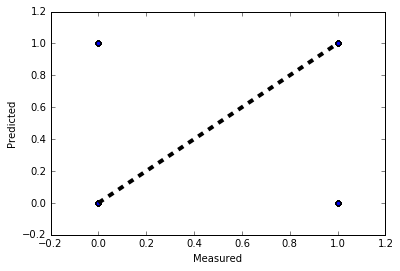

In [171]:
from sklearn.cross_validation import cross_val_predict

predicted = cross_val_predict(gbm, dev_temp, dev_labels, cv=10)

fig, ax = plt.subplots()
ax.scatter(dev_labels, predicted)
ax.plot([dev_labels.min(), dev_labels.max()], [dev_labels.min(), dev_labels.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

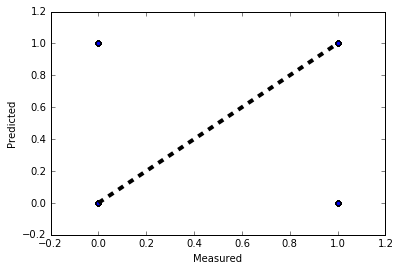

In [172]:
from sklearn.cross_validation import cross_val_predict

predicted = cross_val_predict(gbm, train_temp, train_labels, cv=10)

fig, ax = plt.subplots()
ax.scatter(train_labels, predicted)
ax.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [175]:
cross_validation.cross_val_score(gbm, dev_temp, dev_labels, cv=10, scoring='roc_auc')

array([ 0.81578947,  0.83198381,  0.77546778,  0.92307692,  0.85446985,
        0.79417879,  0.82744283,  0.86902287,  0.83108108,  0.86261261])

In [176]:
cross_validation.cross_val_score(gbm, dev_temp, dev_labels, cv=10, scoring='accuracy')

array([ 0.76470588,  0.82352941,  0.8       ,  0.88      ,  0.8       ,
        0.76      ,  0.84      ,  0.8       ,  0.73469388,  0.81632653])

In [177]:
cross_val_predict(gbm, dev_temp, dev_labels, cv=10)

array([ True, False, False,  True,  True, False, False,  True, False,
       False, False,  True, False, False, False,  True, False,  True,
       False,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False,  True, False, False, False,  True, False,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True, False, False, False,  True,
       False,  True,

In [221]:
train_numeric_pos = train_numeric_data[np.where(train_labels==1)]
train_labels_pos = train_labels[np.where(train_labels==1)]
train_numeric_pos.shape

(1154L, 21L)

In [189]:
train_numeric_neg = train_numeric_data[np.where(train_labels==0)]
train_numeric_neg.shape

(3517L, 21L)

In [ ]:
import random

random.seed(0)

train_wanted = []
train_labels_wanted = []

for i in range(train_numeric_pos.shape[0]):
    rand_index = random.randint(0, train_numeric_pos.shape[0])
    train_wanted.append(train_numeric_data[int(rand_index)])
    train_labels_wanted.append(train_labels[int(rand_index)])

train_wanted = np.asarray(train_wanted)
train_labels_wanted = np.asarray(train_labels_wanted)



train_equal = np.concatenate((train_numeric_pos, train_wanted), axis=0)
train_labels_equal = np.concatenate((train_labels_pos, train_labels_wanted), axis=0)

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_equal, train_labels_equal)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_numeric_data)))
print(metrics.accuracy_score(train_labels_equal, gbm.predict(train_equal)))
print(metrics.roc_auc_score(train_labels_equal, gbm.predict(train_equal)))

print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='roc_auc'))
print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='accuracy'))

In [231]:
train_numeric_pos = train_temp[np.where(train_labels==1)]
train_labels_pos = train_labels[np.where(train_labels==1)]
train_numeric_pos.shape
train_numeric_neg = train_temp[np.where(train_labels==0)]
train_numeric_neg.shape

train_wanted = []
train_labels_wanted = []

for i in range(train_numeric_pos.shape[0]):
    rand_index = random.randint(0, train_numeric_pos.shape[0])
    train_wanted.append(train_temp[int(rand_index)])
    train_labels_wanted.append(train_labels[int(rand_index)])

train_wanted = np.asarray(train_wanted)
train_labels_wanted = np.asarray(train_labels_wanted)

train_equal = np.concatenate((train_numeric_pos, train_wanted), axis=0)
train_labels_equal = np.concatenate((train_labels_pos, train_labels_wanted), axis=0)

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_equal, train_labels_equal)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_temp)))
print(metrics.accuracy_score(train_labels_equal, gbm.predict(train_equal)))
print(metrics.roc_auc_score(train_labels_equal, gbm.predict(train_equal)))

print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='roc_auc'))
print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='accuracy'))

0.71
0.764112903226
1.0
1.0
[ 0.96958784  0.97543017  0.94853942  0.96116035  0.94488316  0.92596217
  0.93240378  0.94944553  0.96697652  0.98499674]
[ 0.92241379  0.93965517  0.89224138  0.92207792  0.87012987  0.85217391
  0.89130435  0.9         0.93913043  0.93913043]


In [232]:
train_numeric_pos = train_tempr[np.where(train_labels==1)]
train_labels_pos = train_labels[np.where(train_labels==1)]
train_numeric_pos.shape
train_numeric_neg = train_tempr[np.where(train_labels==0)]
train_numeric_neg.shape

train_wanted = []
train_labels_wanted = []

for i in range(train_numeric_pos.shape[0]):
    rand_index = random.randint(0, train_numeric_pos.shape[0])
    train_wanted.append(train_tempr[int(rand_index)])
    train_labels_wanted.append(train_labels[int(rand_index)])

train_wanted = np.asarray(train_wanted)
train_labels_wanted = np.asarray(train_labels_wanted)

train_equal = np.concatenate((train_numeric_pos, train_wanted), axis=0)
train_labels_equal = np.concatenate((train_labels_pos, train_labels_wanted), axis=0)

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_equal, train_labels_equal)

print(metrics.accuracy_score(dev_labels, gbm.predict(dev_tempr)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(dev_tempr)))
print(metrics.accuracy_score(train_labels_equal, gbm.predict(train_equal)))
print(metrics.roc_auc_score(train_labels_equal, gbm.predict(train_equal)))

print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='roc_auc'))
print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='accuracy'))

0.724
0.768397177419
1.0
1.0
[ 0.97682383  0.97985027  0.93540937  0.96351243  0.94017642  0.92040568
  0.93322515  0.90580122  0.9873428   0.98166329]
[ 0.92241379  0.92241379  0.85775862  0.91774892  0.86580087  0.85652174
  0.88695652  0.87826087  0.96086957  0.94347826]


In [ ]:
train_numeric_pos = tdf[np.where(train_labels==1)]
train_labels_pos = train_labels[np.where(train_labels==1)]
train_numeric_pos.shape
train_numeric_neg = tdf[np.where(train_labels==0)]
train_numeric_neg.shape

train_wanted = []
train_labels_wanted = []

for i in range(train_numeric_pos.shape[0]):
    rand_index = random.randint(0, train_numeric_pos.shape[0])
    train_wanted.append(tdf[int(rand_index)])
    train_labels_wanted.append(train_labels[int(rand_index)])

train_wanted = np.asarray(train_wanted)
train_labels_wanted = np.asarray(train_labels_wanted)

train_equal = np.concatenate((train_numeric_pos, train_wanted), axis=0)
train_labels_equal = np.concatenate((train_labels_pos, train_labels_wanted), axis=0)

gbm = xgb.XGBClassifier(max_depth=30, n_estimators=500, learning_rate=0.05)

gbm.fit(train_equal, train_labels_equal)

print(metrics.accuracy_score(dev_labels, gbm.predict(ddf)))
print(metrics.roc_auc_score(dev_labels, gbm.predict(ddf)))
print(metrics.accuracy_score(train_labels_equal, gbm.predict(train_equal)))
print(metrics.roc_auc_score(train_labels_equal, gbm.predict(train_equal)))

print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='roc_auc'))
print(cross_validation.cross_val_score(gbm, train_equal, train_labels_equal, cv=10, scoring='accuracy'))

0.402
0.562247983871
0.989168110919
0.985448195576
